# References: https://github.com/youbeebee/deeplearning_from_scratch

수강생분의 이름, 학번을 반영해주세요.

In [87]:
id = '20201944'
name = '안희진'
print(id, name)

20201944 안희진


구글 드라이브 연동

In [88]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


폴더 경로 설정

In [89]:
workspace_path = '/gdrive/My Drive/3-2/인공지능/Al_week9/codes'  # 과제 파일 업로드한 경로 반영

폴더 접근 허용

In [90]:
import sys
sys.path.append(workspace_path)

실험결과 재현 함수

In [91]:
import numpy as np
import random

def seed_everything(seed):
    np.random.seed(seed)
    random.seed(seed)
    # torch.manual_seed(seed)
    # if torch.cuda.is_available():
    #     torch.cuda.manual_seed(seed)
    #     if torch.cuda.device_count() > 1:
    #         torch.cuda.manual_seed_all(seed) # if use multi-GPU
    #     torch.backends.cudnn.deterministic = True
    #     torch.backends.cudnn.benchmark = False

기본 네트워크 구조 정의

In [92]:
# coding: utf-8
import sys, os
sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import numpy as np
from collections import OrderedDict
from common.layers import *
from common.gradient import numerical_gradient


class MultiLayerNet:
    """완전연결 다층 신경망
    Parameters
    ----------
    input_size : 입력 크기（MNIST의 경우엔 784）
    hidden_size_list : 각 은닉층의 뉴런 수를 담은 리스트（e.g. [100, 100, 100]）
    output_size : 출력 크기（MNIST의 경우엔 10）
    activation : 활성화 함수 - 'relu' 혹은 'sigmoid'
    weight_init_std : 가중치의 표준편차 지정（e.g. 0.01）
        'relu'나 'he'로 지정하면 'He 초깃값'으로 설정
        'sigmoid'나 'xavier'로 지정하면 'Xavier 초깃값'으로 설정
    weight_decay_lambda : 가중치 감소(L2 법칙)의 세기
    """
    def __init__(self, input_size, hidden_size_list, output_size,
                 activation='relu', weight_init_std='relu', weight_decay_lambda=0):
        self.input_size = input_size
        self.output_size = output_size
        self.hidden_size_list = hidden_size_list
        self.hidden_layer_num = len(hidden_size_list)
        self.weight_decay_lambda = weight_decay_lambda
        self.params = {}

        # 가중치 초기화
        self.__init_weight(weight_init_std)

        # 계층 생성
        activation_layer = {'sigmoid': Sigmoid, 'relu': Relu}
        self.layers = OrderedDict()
        for idx in range(1, self.hidden_layer_num+1):
            self.layers['Affine' + str(idx)] = Affine(self.params['W' + str(idx)],
                                                      self.params['b' + str(idx)])
            self.layers['Activation_function' + str(idx)] = activation_layer[activation]()

        idx = self.hidden_layer_num + 1
        self.layers['Affine' + str(idx)] = Affine(self.params['W' + str(idx)],
            self.params['b' + str(idx)])

        self.last_layer = SoftmaxWithLoss()

    def __init_weight(self, weight_init_std):
        """가중치 초기화
        
        Parameters
        ----------
        weight_init_std : 가중치의 표준편차 지정（e.g. 0.01）
            'relu'나 'he'로 지정하면 'He 초깃값'으로 설정
            'sigmoid'나 'xavier'로 지정하면 'Xavier 초깃값'으로 설정
        """
        all_size_list = [self.input_size] + self.hidden_size_list + [self.output_size]
        for idx in range(1, len(all_size_list)):
            scale = weight_init_std
            if str(weight_init_std).lower() in ('relu', 'he'):
                scale = np.sqrt(2.0 / all_size_list[idx - 1])  # ReLU를 사용할 때의 권장 초깃값
            elif str(weight_init_std).lower() in ('sigmoid', 'xavier'):
                scale = np.sqrt(1.0 / all_size_list[idx - 1])  # sigmoid를 사용할 때의 권장 초깃값
            self.params['W' + str(idx)] = scale * np.random.randn(all_size_list[idx-1], all_size_list[idx])
            self.params['b' + str(idx)] = np.zeros(all_size_list[idx])

    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)

        return x

    def loss(self, x, t):
        """손실 함수를 구한다.
        
        Parameters
        ----------
        x : 입력 데이터
        t : 정답 레이블 
        
        Returns
        -------
        손실 함수의 값
        """
        y = self.predict(x)

        weight_decay = 0
        for idx in range(1, self.hidden_layer_num + 2):
            W = self.params['W' + str(idx)]
            # L2 regularization (weight decay lambda 사용)
            weight_decay += 0.5 * self.weight_decay_lambda * np.sum(W ** 2)

        return self.last_layer.forward(y, t) + weight_decay

    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        if t.ndim != 1 : t = np.argmax(t, axis=1)

        accuracy = np.sum(y == t) / float(x.shape[0])
        return accuracy

    def numerical_gradient(self, x, t):
        """기울기를 구한다(수치 미분).
        
        Parameters
        ----------
        x : 입력 데이터
        t : 정답 레이블
        
        Returns
        -------
        각 층의 기울기를 담은 딕셔너리(dictionary) 변수
            grads['W1']、grads['W2']、... 각 층의 가중치
            grads['b1']、grads['b2']、... 각 층의 편향
        """
        loss_W = lambda W: self.loss(x, t)

        grads = {}
        for idx in range(1, self.hidden_layer_num+2):
            grads['W' + str(idx)] = numerical_gradient(loss_W, self.params['W' + str(idx)])
            grads['b' + str(idx)] = numerical_gradient(loss_W, self.params['b' + str(idx)])

        return grads

    def gradient(self, x, t):
        """기울기를 구한다(오차역전파법).
        Parameters
        ----------
        x : 입력 데이터
        t : 정답 레이블
        
        Returns
        -------
        각 층의 기울기를 담은 딕셔너리(dictionary) 변수
            grads['W1']、grads['W2']、... 각 층의 가중치
            grads['b1']、grads['b2']、... 각 층의 편향
        """
        # forward
        self.loss(x, t)

        # backward
        dout = 1
        dout = self.last_layer.backward(dout)

        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)

        # 결과 저장
        grads = {}
        for idx in range(1, self.hidden_layer_num+2):
            # grads = grads + grad_of_regularization()
            grads['W' + str(idx)] = self.layers['Affine' + str(idx)].dW + self.weight_decay_lambda * self.layers['Affine' + str(idx)].W
            grads['b' + str(idx)] = self.layers['Affine' + str(idx)].db

        return grads

# 1. 최적화 방법(optimizer)

- PyTorch optimizer 문서
 - https://pytorch.org/docs/stable/optim.html

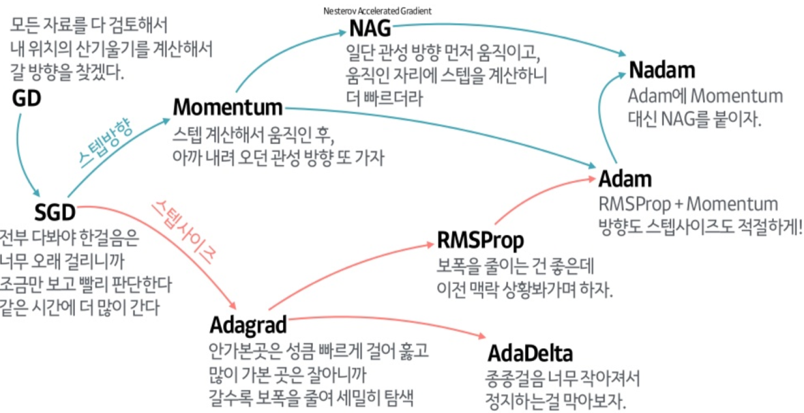

그림 출처: 하용호, 자습해도 모르겠던 딥러닝, 머리속에 인스톨 시켜드립니다

확률적 경사 하강법(SGD)

In [93]:
"""
신경망 학습의 목적 : 손실 함수의 값을 최대한 낮추는 매개변수를 찾는 것 - 최적화optimization
최적의 매개변수 값을 찾는 단서로 매개변수의 기울기(미분)을 이용함 - 확률적 경사 하강법(SGD)
SGD의 단점과 다른 최적화 기법을 소개
"""

# 6.1.1 모험가 이야기
# 6.1.2 확률적 경사 하강법(SGD)
"""
W ← W - η * ∂L/∂W
W : 갱신할 가중치 매개변수
∂L/∂W : W에 대한 손실 함수의 기울기
η : 학습률(정해진 상수값. 0.01, 0.001 등)
"""


# 최적화를 담당하는 클래스를 분리해 구현하면 기능을 모듈화하기 좋다.
class SGD:
    def __init__(self, lr=0.01):
        self.lr = lr

    def update(self, params, grads):
        for key in params.keys():
            params[key] -= self.lr * grads[key]


# 6.1.3 SGD의 단점
"""
SGD는 단순하고구현이 쉽지만, 문제에 따라 비효율적일 때가 있다.
다음 함수의 최솟값을 구해보자
f(x, y) = 1/20 * x² + y²
각 점에서 함수의 기울기는 (x/10, 2y)로 y축 방향은 가파른데 x축 방향은 완만하다.
또 최솟값은 (0, 0)이지만 기울기 대부분은 그 방향을 가리키지 않는다.
따라서 SGD를 적용하면 y축으로 지그재그로 수렴한다.
SGD는 비등방성anisotropy 함수(방향에 따라 성질, 여기서는 기울기가 달라지는 함수)에서는
탐색 경로가 비효율적이다.
이러한 단점을 개선해주는 모멘텀, AdaGrad, Adam이라는 방법을 소개한다.
"""
print()

모멘텀(SGD+momentum)

In [94]:
# 6.1.4 모멘텀
"""
모멘텀Momentum : 물리에서의 운동량
v ← αv - η * ∂L/∂W
W ← W + v
W : 갱신할 가중치 매개변수
∂L/∂W : W에 대한 손실 함수의 기울기
η : 학습률
v : 속도. 기울기 방향으로 힘을 받아 물체가 가속되는 것을 나타냄
α : 마찰/저항에 해당(0.9)
마치 공이 바닥을 구르는 듯한 움직임을 보여준다.
"""


class Momentum:
    def __init__(self, lr=0.01, momentum=0.9):
        self.lr = lr
        self.momentum = momentum
        self.v = None

    def update(self, params, grads):
        if self.v is None:
            self.v = {}
            for key, val in params.items():
                self.v[key] = np.zeros_like(val)

        for key in params.keys():
            self.v[key] = self.momentum * self.v[key] - self.lr * grads[key]
            params[key] += self.v[key]

AdaGrad

In [95]:
# 6.1.5 AdaGrad
"""
학습률이 너무 작으면 학습 시간이 길어지고 너무 크면 발산한다.다
학습률을 정하는 효과적인 기술로 학습률 감소learning rate decay가 있다.
학습을 진행하면서 학습률을 점차 줄여나간다.
AdaGrad 방식은 각각의 매개변수에 맞춰 적응적으로 학습률을 조정하며 학습을 진행한다.
h ← h + ∂L/∂W ⊙ ∂L/∂W
W ← W - η *1/√h * ∂L/∂W
⊙ : 행렬의 원소별 곱셈
h는 기존 기울기를 제곱해서 누적하며, 매개변수 갱신에 1/√h를 곱해준다.
매개변수가 크게 갠신된 원소는 학습률이 낮아진다.
NOTE : AdaGrad는 과거의 기울기를 제곱하여 계속 더하기 때문에 학습을 진행할 수록
갱신 강도가 약해진다. 이 문제를 개선한 기법으로 RMSProp이 있다.
RMSProp에서는 먼 과거의 기울기는 서서히 잊고 새로운 기울기 정보를 크게 반영한다.
이를 지수이동평균Exponential Moving Average이라 하며 과거 기울기의 반영 규모를
기하급수적으로 감소시킨다.
"""


class AdaGrad:
    def __init__(self, lr=0.01):
        self.lr = lr
        self.h = None

    def update(self, params, grads):
        if self.h is None:
            self.h = {}

            for key, val in params.items():
                self.h[key] = np.zeros_like(val)

        for key in params.keys():
            self.h[key] += grads[key] * grads[key]
            params[key] -= self.lr * grads[key] / (np.sqrt(self.h[key]) + 1e-7)
            # 1e-7 : h[key]에 0이 있는 경우 0으로 나누는 것을 방지. 이 값도 설정 가능


RMSprop

In [96]:
class RMSprop:
    """RMSprop"""
    def __init__(self, lr=0.01, decay_rate = 0.99):
        self.lr = lr
        self.decay_rate = decay_rate
        self.h = None
        
    def update(self, params, grads):
        if self.h is None:
            self.h = {}
            for key, val in params.items():
                self.h[key] = np.zeros_like(val)
            
        for key in params.keys():
            self.h[key] *= self.decay_rate
            self.h[key] += (1 - self.decay_rate) * grads[key] * grads[key]
            params[key] -= self.lr * grads[key] / (np.sqrt(self.h[key]) + 1e-7)

Adam

In [97]:
class Adam:
    """Adam (http://arxiv.org/abs/1412.6980v8)"""
    def __init__(self, lr=0.001, beta1=0.9, beta2=0.999):
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.iter = 0
        self.m = None
        self.v = None
        
    def update(self, params, grads):
        if self.m is None:
            self.m, self.v = {}, {}
            for key, val in params.items():
                self.m[key] = np.zeros_like(val)
                self.v[key] = np.zeros_like(val)
        
        self.iter += 1
        lr_t  = self.lr * np.sqrt(1.0 - self.beta2**self.iter) / (1.0 - self.beta1**self.iter)         
        
        for key in params.keys():
            #self.m[key] = self.beta1*self.m[key] + (1-self.beta1)*grads[key]
            #self.v[key] = self.beta2*self.v[key] + (1-self.beta2)*(grads[key]**2)
            self.m[key] += (1 - self.beta1) * (grads[key] - self.m[key])
            self.v[key] += (1 - self.beta2) * (grads[key]**2 - self.v[key])
            
            params[key] -= lr_t * self.m[key] / (np.sqrt(self.v[key]) + 1e-7)
            
            #unbias_m += (1 - self.beta1) * (grads[key] - self.m[key]) # correct bias
            #unbisa_b += (1 - self.beta2) * (grads[key]*grads[key] - self.v[key]) # correct bias
            #params[key] += self.lr * unbias_m / (np.sqrt(unbisa_b) + 1e-7)

## 최적화 방법 비교 on MNIST

/gdrive/My Drive/3-2/인공지능/Al_week9/codes/common/functions.py:56: RuntimeWarning: divide by zero encountered in log
  return -np.sum(np.log(y[np.arange(batch_size), t])) / batch_size


===========iteration:0===========
SGD:2.3513930380338555
Momentum:2.325133231409226
AdaGrad:2.096001166084077
RMSprop:inf
Adam:2.0866624867227577
===========iteration:100===========
SGD:1.48781900814293
Momentum:0.41962980441848396
AdaGrad:0.2240221238799771
RMSprop:0.42274092613076725
Adam:0.3629178118945503
===========iteration:200===========
SGD:0.69115207281201
Momentum:0.23407330066141527
AdaGrad:0.10619409138128791
RMSprop:0.1795798059583023
Adam:0.21126312341398598
===========iteration:300===========
SGD:0.5278636014599523
Momentum:0.18986897134860142
AdaGrad:0.0699596796871386
RMSprop:0.19844970637015535
Adam:0.14361921767635247
===========iteration:400===========
SGD:0.43757020012149184
Momentum:0.19329519450156082
AdaGrad:0.09939993063112212
RMSprop:0.12298497544828005
Adam:0.13666703572061484
===========iteration:500===========
SGD:0.3594523275260283
Momentum:0.15282188884013645
AdaGrad:0.07721567158913485
RMSprop:0.09074370307044981
Adam:0.10574044399267352
===========itera

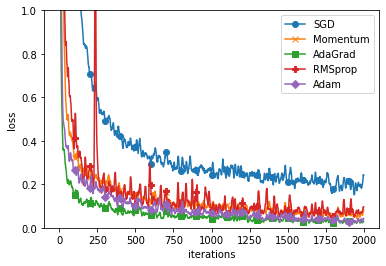

In [98]:
# coding: utf-8
import os
import sys
import matplotlib.pyplot as plt
import numpy as np
from dataset.mnist import load_mnist
sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
from common.multi_layer_net import MultiLayerNet
from common.util import smooth_curve
from common.optimizer import *


# 0. MNIST 데이터 읽기==========
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

train_size = x_train.shape[0]
batch_size = 128
max_iterations = 2000
seed = 0


# 1. 실험용 설정==========
optimizers = {}
seed_everything(seed)
optimizers['SGD'] = SGD()
seed_everything(seed)
optimizers['Momentum'] = Momentum()
seed_everything(seed)
optimizers['AdaGrad'] = AdaGrad()
seed_everything(seed)
optimizers['RMSprop'] = RMSprop()
seed_everything(seed)
optimizers['Adam'] = Adam()

networks = {}
train_loss = {}
# optimizer 별로 모델 생성
for key in optimizers.keys():
    networks[key] = MultiLayerNet(
        input_size=784, hidden_size_list=[100, 100, 100, 100],
        output_size=10)
    train_loss[key] = []


# 2. 훈련 시작==========
for i in range(max_iterations):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]

    for key in optimizers.keys():
        grads = networks[key].gradient(x_batch, t_batch)
        optimizers[key].update(networks[key].params, grads)

        loss = networks[key].loss(x_batch, t_batch)
        train_loss[key].append(loss)

    if i % 100 == 0:
        print("===========" + "iteration:" + str(i) + "===========")
        for key in optimizers.keys():
            loss = networks[key].loss(x_batch, t_batch)
            print(key + ":" + str(loss))

# 3. 그래프 그리기==========
markers = {"SGD": "o", "Momentum": "x", "AdaGrad": "s", "RMSprop": "P", "Adam": "D"}
x = np.arange(max_iterations)
for key in optimizers.keys():
    plt.plot(x, smooth_curve(train_loss[key]), marker=markers[key],
             markevery=100, label=key)
plt.xlabel("iterations")
plt.ylabel("loss")
plt.ylim(0, 1)
plt.legend()
plt.show()

# 2. 가중치 초기화 방법(weight initialization) 비교

===========iteration:0===========
std=0.01:2.3024715916869116
Xavier:2.3138762333230276
He:2.434893461445524
===========iteration:100===========
std=0.01:2.30234787834822
Xavier:2.2434619829553952
He:1.400838822306473
===========iteration:200===========
std=0.01:2.3024858621566118
Xavier:2.1106332730105954
He:0.6443314710983618
===========iteration:300===========
std=0.01:2.299139354903081
Xavier:1.7441316709480224
He:0.587827146195415
===========iteration:400===========
std=0.01:2.300176351224311
Xavier:1.1671966889422452
He:0.3478515109317826
===========iteration:500===========
std=0.01:2.300468513880777
Xavier:0.895236458603784
He:0.3714894424825098
===========iteration:600===========
std=0.01:2.304415658700598
Xavier:0.6229374477444565
He:0.3317873591887578
===========iteration:700===========
std=0.01:2.301400756214629
Xavier:0.591060632771711
He:0.37160020268511124
===========iteration:800===========
std=0.01:2.3009254520111018
Xavier:0.5974578818689411
He:0.351131172663158
======

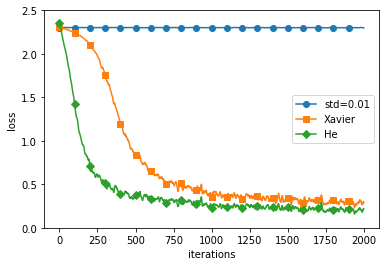

In [99]:
# coding: utf-8
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
from dataset.mnist import load_mnist
from common.multi_layer_net import MultiLayerNet
from common.util import smooth_curve
from common.optimizer import *


# 0. MNIST 데이터 읽기==========
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

train_size = x_train.shape[0]
batch_size = 128
max_iterations = 2000
seed = 0


# 1. 실험용 설정==========
weight_init_types = {'std=0.01': 0.01, 'Xavier': 'sigmoid', 'He': 'relu'}
optimizer = SGD(lr=0.01)

networks = {}
train_loss = {}
# optimizer 별로 모델 생성
for key, weight_type in weight_init_types.items():
    seed_everything(seed)
    networks[key] = MultiLayerNet(input_size=784, hidden_size_list=[100, 100, 100, 100],
                                  output_size=10, weight_init_std=weight_type)
    train_loss[key] = []


# 2. 훈련 시작==========
for i in range(max_iterations):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]

    for key in weight_init_types.keys():
        grads = networks[key].gradient(x_batch, t_batch)
        optimizer.update(networks[key].params, grads)

        loss = networks[key].loss(x_batch, t_batch)
        train_loss[key].append(loss)

    if i % 100 == 0:
        print("===========" + "iteration:" + str(i) + "===========")
        for key in weight_init_types.keys():
            loss = networks[key].loss(x_batch, t_batch)
            print(key + ":" + str(loss))

# 3. 그래프 그리기==========
markers = {'std=0.01': 'o', 'Xavier': 's', 'He': 'D'}
x = np.arange(max_iterations)
for key in weight_init_types.keys():
    plt.plot(x, smooth_curve(train_loss[key]), marker=markers[key], markevery=100, label=key)
plt.xlabel("iterations")
plt.ylabel("loss")
plt.ylim(0, 2.5)
plt.legend()
plt.show()

# 3. 배치 정규화(batch normalization)

============== 1/16 ==============
epoch:0 | 0.094 - 0.087


/gdrive/My Drive/3-2/인공지능/Al_week9/codes/common/functions.py:56: RuntimeWarning: divide by zero encountered in log
  return -np.sum(np.log(y[np.arange(batch_size), t])) / batch_size
/gdrive/My Drive/3-2/인공지능/Al_week9/codes/common/multi_layer_net_extend.py:104: RuntimeWarning: overflow encountered in square
  weight_decay += 0.5 * self.weight_decay_lambda * np.sum(W**2)
/gdrive/My Drive/3-2/인공지능/Al_week9/codes/common/multi_layer_net_extend.py:104: RuntimeWarning: invalid value encountered in double_scalars
  weight_decay += 0.5 * self.weight_decay_lambda * np.sum(W**2)
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


epoch:1 | 0.097 - 0.101
epoch:2 | 0.097 - 0.143
epoch:3 | 0.097 - 0.164
epoch:4 | 0.097 - 0.174
epoch:5 | 0.097 - 0.197
epoch:6 | 0.097 - 0.229
epoch:7 | 0.097 - 0.252
epoch:8 | 0.097 - 0.283
epoch:9 | 0.097 - 0.311
epoch:10 | 0.097 - 0.315
epoch:11 | 0.097 - 0.332
epoch:12 | 0.097 - 0.344
epoch:13 | 0.097 - 0.369
epoch:14 | 0.097 - 0.378
epoch:15 | 0.097 - 0.394
epoch:16 | 0.097 - 0.403
epoch:17 | 0.097 - 0.416
epoch:18 | 0.097 - 0.431


epoch:19 | 0.097 - 0.445
============== 2/16 ==============
epoch:0 | 0.1 - 0.087


/gdrive/My Drive/3-2/인공지능/Al_week9/codes/common/functions.py:56: RuntimeWarning: divide by zero encountered in log
  return -np.sum(np.log(y[np.arange(batch_size), t])) / batch_size
/gdrive/My Drive/3-2/인공지능/Al_week9/codes/common/multi_layer_net_extend.py:104: RuntimeWarning: overflow encountered in square
  weight_decay += 0.5 * self.weight_decay_lambda * np.sum(W**2)
/gdrive/My Drive/3-2/인공지능/Al_week9/codes/common/multi_layer_net_extend.py:104: RuntimeWarning: invalid value encountered in double_scalars
  weight_decay += 0.5 * self.weight_decay_lambda * np.sum(W**2)
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


epoch:1 | 0.097 - 0.101
epoch:2 | 0.097 - 0.148
epoch:3 | 0.097 - 0.164
epoch:4 | 0.097 - 0.191
epoch:5 | 0.097 - 0.212
epoch:6 | 0.097 - 0.254
epoch:7 | 0.097 - 0.278
epoch:8 | 0.097 - 0.312
epoch:9 | 0.097 - 0.331
epoch:10 | 0.097 - 0.355
epoch:11 | 0.097 - 0.365
epoch:12 | 0.097 - 0.388
epoch:13 | 0.097 - 0.417
epoch:14 | 0.097 - 0.445
epoch:15 | 0.097 - 0.463
epoch:16 | 0.097 - 0.47
epoch:17 | 0.097 - 0.495
epoch:18 | 0.097 - 0.503


epoch:19 | 0.097 - 0.522
============== 3/16 ==============
epoch:0 | 0.103 - 0.087


/gdrive/My Drive/3-2/인공지능/Al_week9/codes/common/functions.py:56: RuntimeWarning: divide by zero encountered in log
  return -np.sum(np.log(y[np.arange(batch_size), t])) / batch_size


epoch:1 | 0.282 - 0.105
epoch:2 | 0.398 - 0.167
epoch:3 | 0.503 - 0.199
epoch:4 | 0.616 - 0.231
epoch:5 | 0.677 - 0.276
epoch:6 | 0.726 - 0.32
epoch:7 | 0.768 - 0.375
epoch:8 | 0.787 - 0.412
epoch:9 | 0.812 - 0.462
epoch:10 | 0.842 - 0.481
epoch:11 | 0.855 - 0.511
epoch:12 | 0.881 - 0.534
epoch:13 | 0.91 - 0.557
epoch:14 | 0.917 - 0.577
epoch:15 | 0.92 - 0.607
epoch:16 | 0.933 - 0.625
epoch:17 | 0.935 - 0.646
epoch:18 | 0.954 - 0.655


epoch:19 | 0.95 - 0.676
============== 4/16 ==============
epoch:0 | 0.094 - 0.089
epoch:1 | 0.293 - 0.11
epoch:2 | 0.413 - 0.202
epoch:3 | 0.504 - 0.265
epoch:4 | 0.563 - 0.339
epoch:5 | 0.64 - 0.43
epoch:6 | 0.68 - 0.497
epoch:7 | 0.703 - 0.553
epoch:8 | 0.757 - 0.602
epoch:9 | 0.773 - 0.633
epoch:10 | 0.786 - 0.651
epoch:11 | 0.797 - 0.678
epoch:12 | 0.821 - 0.7
epoch:13 | 0.816 - 0.73
epoch:14 | 0.815 - 0.744
epoch:15 | 0.833 - 0.769
epoch:16 | 0.855 - 0.788
epoch:17 | 0.844 - 0.802
epoch:18 | 0.86 - 0.815


epoch:19 | 0.869 - 0.833
============== 5/16 ==============
epoch:0 | 0.09 - 0.088
epoch:1 | 0.094 - 0.142
epoch:2 | 0.096 - 0.305
epoch:3 | 0.103 - 0.427
epoch:4 | 0.109 - 0.528
epoch:5 | 0.118 - 0.632
epoch:6 | 0.129 - 0.679
epoch:7 | 0.138 - 0.723
epoch:8 | 0.157 - 0.761
epoch:9 | 0.173 - 0.797
epoch:10 | 0.187 - 0.812
epoch:11 | 0.203 - 0.829
epoch:12 | 0.222 - 0.848
epoch:13 | 0.226 - 0.86
epoch:14 | 0.249 - 0.869
epoch:15 | 0.256 - 0.883
epoch:16 | 0.262 - 0.891
epoch:17 | 0.271 - 0.9
epoch:18 | 0.27 - 0.911
epoch:19 | 0.266 - 0.917


============== 6/16 ==============
epoch:0 | 0.09 - 0.09
epoch:1 | 0.123 - 0.203
epoch:2 | 0.117 - 0.466
epoch:3 | 0.117 - 0.639
epoch:4 | 0.117 - 0.727
epoch:5 | 0.117 - 0.769
epoch:6 | 0.117 - 0.806
epoch:7 | 0.117 - 0.822
epoch:8 | 0.117 - 0.836
epoch:9 | 0.117 - 0.852
epoch:10 | 0.117 - 0.868
epoch:11 | 0.117 - 0.883
epoch:12 | 0.117 - 0.908
epoch:13 | 0.117 - 0.911
epoch:14 | 0.117 - 0.925
epoch:15 | 0.117 - 0.94
epoch:16 | 0.117 - 0.946
epoch:17 | 0.117 - 0.951
epoch:18 | 0.117 - 0.956


epoch:19 | 0.117 - 0.964
============== 7/16 ==============
epoch:0 | 0.105 - 0.089
epoch:1 | 0.117 - 0.32
epoch:2 | 0.117 - 0.644
epoch:3 | 0.117 - 0.778
epoch:4 | 0.117 - 0.807
epoch:5 | 0.117 - 0.818
epoch:6 | 0.117 - 0.842
epoch:7 | 0.117 - 0.854
epoch:8 | 0.105 - 0.879
epoch:9 | 0.117 - 0.904
epoch:10 | 0.117 - 0.925
epoch:11 | 0.117 - 0.94
epoch:12 | 0.117 - 0.952
epoch:13 | 0.117 - 0.961
epoch:14 | 0.117 - 0.972
epoch:15 | 0.117 - 0.977
epoch:16 | 0.117 - 0.982
epoch:17 | 0.117 - 0.986
epoch:18 | 0.117 - 0.987


epoch:19 | 0.117 - 0.988
============== 8/16 ==============
epoch:0 | 0.113 - 0.093
epoch:1 | 0.117 - 0.501
epoch:2 | 0.117 - 0.744
epoch:3 | 0.117 - 0.783
epoch:4 | 0.117 - 0.801
epoch:5 | 0.117 - 0.836
epoch:6 | 0.117 - 0.883
epoch:7 | 0.117 - 0.902
epoch:8 | 0.105 - 0.926
epoch:9 | 0.117 - 0.949
epoch:10 | 0.117 - 0.971
epoch:11 | 0.117 - 0.983
epoch:12 | 0.117 - 0.987
epoch:13 | 0.117 - 0.992
epoch:14 | 0.117 - 0.993
epoch:15 | 0.117 - 0.995
epoch:16 | 0.117 - 0.995
epoch:17 | 0.117 - 0.997
epoch:18 | 0.117 - 0.997


epoch:19 | 0.117 - 0.997
============== 9/16 ==============
epoch:0 | 0.118 - 0.102
epoch:1 | 0.117 - 0.615
epoch:2 | 0.117 - 0.731
epoch:3 | 0.117 - 0.761
epoch:4 | 0.117 - 0.805
epoch:5 | 0.117 - 0.887
epoch:6 | 0.117 - 0.922
epoch:7 | 0.117 - 0.949
epoch:8 | 0.105 - 0.976
epoch:9 | 0.117 - 0.987
epoch:10 | 0.117 - 0.994
epoch:11 | 0.117 - 0.996
epoch:12 | 0.117 - 0.995
epoch:13 | 0.117 - 0.997
epoch:14 | 0.117 - 0.999
epoch:15 | 0.117 - 1.0
epoch:16 | 0.117 - 1.0
epoch:17 | 0.117 - 1.0
epoch:18 | 0.117 - 1.0


epoch:19 | 0.117 - 1.0
============== 10/16 ==============
epoch:0 | 0.117 - 0.134
epoch:1 | 0.117 - 0.638
epoch:2 | 0.117 - 0.735
epoch:3 | 0.117 - 0.709
epoch:4 | 0.117 - 0.79
epoch:5 | 0.117 - 0.859
epoch:6 | 0.117 - 0.928
epoch:7 | 0.117 - 0.889
epoch:8 | 0.105 - 0.979
epoch:9 | 0.117 - 0.952
epoch:10 | 0.117 - 0.991
epoch:11 | 0.117 - 0.998
epoch:12 | 0.117 - 1.0
epoch:13 | 0.117 - 0.993
epoch:14 | 0.117 - 1.0
epoch:15 | 0.117 - 1.0
epoch:16 | 0.117 - 1.0
epoch:17 | 0.117 - 1.0
epoch:18 | 0.117 - 1.0
epoch:19 | 0.117 - 1.0


============== 11/16 ==============
epoch:0 | 0.117 - 0.215
epoch:1 | 0.117 - 0.656
epoch:2 | 0.117 - 0.649
epoch:3 | 0.117 - 0.684
epoch:4 | 0.117 - 0.691
epoch:5 | 0.117 - 0.669
epoch:6 | 0.117 - 0.722
epoch:7 | 0.117 - 0.827
epoch:8 | 0.105 - 0.856
epoch:9 | 0.117 - 0.833
epoch:10 | 0.117 - 0.877
epoch:11 | 0.117 - 0.924
epoch:12 | 0.117 - 0.962
epoch:13 | 0.117 - 0.973
epoch:14 | 0.117 - 0.984
epoch:15 | 0.117 - 0.99
epoch:16 | 0.117 - 0.987
epoch:17 | 0.117 - 0.993
epoch:18 | 0.117 - 0.962
epoch:19 | 0.117 - 0.991


============== 12/16 ==============
epoch:0 | 0.117 - 0.193
epoch:1 | 0.117 - 0.646
epoch:2 | 0.117 - 0.597
epoch:3 | 0.117 - 0.718
epoch:4 | 0.117 - 0.719
epoch:5 | 0.117 - 0.659
epoch:6 | 0.117 - 0.757
epoch:7 | 0.117 - 0.747
epoch:8 | 0.105 - 0.778
epoch:9 | 0.117 - 0.775
epoch:10 | 0.117 - 0.777
epoch:11 | 0.117 - 0.785
epoch:12 | 0.117 - 0.751
epoch:13 | 0.117 - 0.79
epoch:14 | 0.117 - 0.803
epoch:15 | 0.117 - 0.805
epoch:16 | 0.117 - 0.803
epoch:17 | 0.117 - 0.811
epoch:18 | 0.117 - 0.811


epoch:19 | 0.117 - 0.809
============== 13/16 ==============
epoch:0 | 0.117 - 0.14
epoch:1 | 0.117 - 0.555
epoch:2 | 0.117 - 0.655
epoch:3 | 0.117 - 0.667
epoch:4 | 0.117 - 0.713
epoch:5 | 0.117 - 0.631
epoch:6 | 0.117 - 0.73
epoch:7 | 0.117 - 0.738
epoch:8 | 0.105 - 0.734
epoch:9 | 0.117 - 0.766
epoch:10 | 0.117 - 0.778
epoch:11 | 0.117 - 0.775
epoch:12 | 0.117 - 0.798
epoch:13 | 0.117 - 0.779
epoch:14 | 0.117 - 0.791
epoch:15 | 0.117 - 0.776
epoch:16 | 0.117 - 0.742
epoch:17 | 0.117 - 0.754
epoch:18 | 0.117 - 0.731


epoch:19 | 0.117 - 0.721
============== 14/16 ==============
epoch:0 | 0.117 - 0.112
epoch:1 | 0.117 - 0.471
epoch:2 | 0.117 - 0.478
epoch:3 | 0.117 - 0.581
epoch:4 | 0.117 - 0.598
epoch:5 | 0.117 - 0.537
epoch:6 | 0.117 - 0.659
epoch:7 | 0.117 - 0.652
epoch:8 | 0.105 - 0.689
epoch:9 | 0.117 - 0.701
epoch:10 | 0.117 - 0.698
epoch:11 | 0.117 - 0.703
epoch:12 | 0.117 - 0.659
epoch:13 | 0.117 - 0.701
epoch:14 | 0.117 - 0.709
epoch:15 | 0.117 - 0.758
epoch:16 | 0.117 - 0.761
epoch:17 | 0.117 - 0.638
epoch:18 | 0.117 - 0.77
epoch:19 | 0.117 - 0.806


============== 15/16 ==============
epoch:0 | 0.117 - 0.114
epoch:1 | 0.117 - 0.317
epoch:2 | 0.117 - 0.388
epoch:3 | 0.117 - 0.483
epoch:4 | 0.117 - 0.487
epoch:5 | 0.117 - 0.482
epoch:6 | 0.117 - 0.484
epoch:7 | 0.117 - 0.484
epoch:8 | 0.105 - 0.501
epoch:9 | 0.117 - 0.498
epoch:10 | 0.117 - 0.499
epoch:11 | 0.117 - 0.511
epoch:12 | 0.117 - 0.691
epoch:13 | 0.117 - 0.628
epoch:14 | 0.117 - 0.688
epoch:15 | 0.117 - 0.652
epoch:16 | 0.117 - 0.659
epoch:17 | 0.117 - 0.654
epoch:18 | 0.117 - 0.673


epoch:19 | 0.117 - 0.713
============== 16/16 ==============
epoch:0 | 0.117 - 0.182
epoch:1 | 0.117 - 0.3
epoch:2 | 0.117 - 0.353
epoch:3 | 0.117 - 0.406
epoch:4 | 0.117 - 0.45
epoch:5 | 0.117 - 0.479
epoch:6 | 0.117 - 0.492
epoch:7 | 0.117 - 0.499
epoch:8 | 0.105 - 0.501
epoch:9 | 0.117 - 0.449
epoch:10 | 0.117 - 0.506
epoch:11 | 0.117 - 0.517
epoch:12 | 0.117 - 0.513
epoch:13 | 0.117 - 0.507
epoch:14 | 0.117 - 0.522
epoch:15 | 0.117 - 0.519
epoch:16 | 0.117 - 0.523
epoch:17 | 0.117 - 0.516
epoch:18 | 0.117 - 0.51
epoch:19 | 0.117 - 0.517


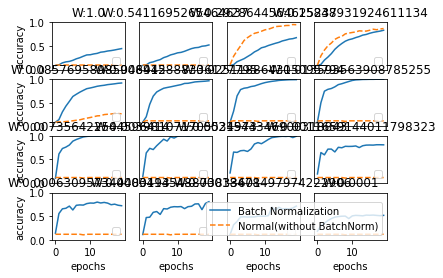

In [100]:
# coding: utf-8
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
from dataset.mnist import load_mnist
from common.multi_layer_net_extend import MultiLayerNetExtend  # MultiLayerNet에 가중치 감소, 드롭아웃, 배치 정규화 추가
from common.optimizer import *

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

# 학습 데이터를 줄임
x_train = x_train[:1000]
t_train = t_train[:1000]

max_epochs = 20
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.01


def __train(weight_init_std):
    # with BN, w/o BN 모델 생성
    seed_everything(seed)
    bn_network = MultiLayerNetExtend(input_size=784,
                                     hidden_size_list=[100, 100, 100, 100, 100],
                                     output_size=10,
                                     weight_init_std=weight_init_std,
                                     use_batchnorm=True)
    seed_everything(seed)
    network = MultiLayerNetExtend(input_size=784,
                                  hidden_size_list=[100, 100, 100, 100, 100],
                                  output_size=10,
                                  weight_init_std=weight_init_std)
    optimizer = SGD(lr=learning_rate)

    train_acc_list = []
    bn_train_acc_list = []

    iter_per_epoch = max(train_size / batch_size, 1)
    epoch_cnt = 0

    for i in range(1000000000):
        batch_mask = np.random.choice(train_size, batch_size)
        x_batch = x_train[batch_mask]
        t_batch = t_train[batch_mask]

        for _network in (bn_network, network):
            grads = _network.gradient(x_batch, t_batch)
            optimizer.update(_network.params, grads)

        if i % iter_per_epoch == 0:
            train_acc = network.accuracy(x_train, t_train)
            bn_train_acc = bn_network.accuracy(x_train, t_train)
            train_acc_list.append(train_acc)
            bn_train_acc_list.append(bn_train_acc)

            print("epoch:" + str(epoch_cnt) + " | " + str(train_acc) + " - "
                  + str(bn_train_acc))

            epoch_cnt += 1
            if epoch_cnt >= max_epochs:
                break

    return train_acc_list, bn_train_acc_list


# 그래프 그리기==========
weight_scale_list = np.logspace(0, -4, num=16)
x = np.arange(max_epochs)

for i, w in enumerate(weight_scale_list):
    print("============== " + str(i+1) + "/16" + " ==============")
    train_acc_list, bn_train_acc_list = __train(w)

    plt.subplot(4, 4, i+1)
    plt.title("W:" + str(w))
    if i == 15:
        plt.plot(x, bn_train_acc_list,
                 label='Batch Normalization', markevery=2)
        plt.plot(x, train_acc_list, linestyle="--",
                 label='Normal(without BatchNorm)', markevery=2)
    else:
        plt.plot(x, bn_train_acc_list, markevery=2)
        plt.plot(x, train_acc_list, linestyle="--", markevery=2)

    plt.ylim(0, 1.0)
    if i % 4:
        plt.yticks([])
    else:
        plt.ylabel("accuracy")
    if i < 12:
        plt.xticks([])
    else:
        plt.xlabel("epochs")
    plt.legend(loc='lower right')

plt.show()

# 4. 과적합(overfitting) 해결 방법

가중치 감쇠(weight decay)

weight_decay = 0 실험

epoch:0, train acc:0.12333333333333334, test acc:0.1047
epoch:1, train acc:0.16333333333333333, test acc:0.1289
epoch:2, train acc:0.19666666666666666, test acc:0.1485
epoch:3, train acc:0.22666666666666666, test acc:0.1651
epoch:4, train acc:0.24, test acc:0.1796
epoch:5, train acc:0.27, test acc:0.2047
epoch:6, train acc:0.30666666666666664, test acc:0.222
epoch:7, train acc:0.35333333333333333, test acc:0.2442
epoch:8, train acc:0.39666666666666667, test acc:0.2863
epoch:9, train acc:0.42, test acc:0.3069
epoch:10, train acc:0.46, test acc:0.3205
epoch:11, train acc:0.5, test acc:0.3352
epoch:12, train acc:0.52, test acc:0.3686
epoch:13, train acc:0.5533333333333333, test acc:0.3931
epoch:14, train acc:0.59, test acc:0.4102
epoch:15, train acc:0.6033333333333334, test acc:0.4111
epoch:16, train acc:0.61, test acc:0.4185
epoch:17, train acc:0.61, test acc:0.4306
epoch:18, train acc:0.6366666666666667, test acc:0.4434
epoch:19, train acc:0.6566666666666666, test acc:0.4617
epoch:20, t

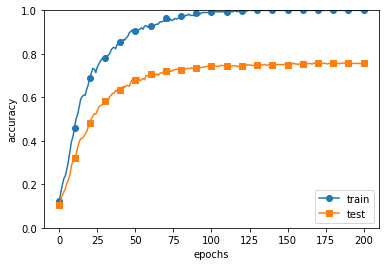

In [101]:
# coding: utf-8
import os
import sys

sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import numpy as np
import matplotlib.pyplot as plt
from common.multi_layer_net import MultiLayerNet
from dataset.mnist import load_mnist
from common.optimizer import *

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

# 오버피팅을 재현하기 위해 학습 데이터 수를 줄임
x_train = x_train[:300]
t_train = t_train[:300]

# weight decay（가중치 감쇠） 설정 =======================
weight_decay_lambda = 0 # weight decay를 사용하지 않을 경우
# weight_decay_lambda = 0.1
seed = 0
# ====================================================

seed_everything(seed)
network = MultiLayerNet(input_size=784, hidden_size_list=[100, 100, 100, 100, 100, 100], output_size=10,
                        weight_decay_lambda=weight_decay_lambda)
optimizer = SGD(lr=0.01) # 학습률이 0.01인 SGD로 매개변수 갱신

max_epochs = 201
train_size = x_train.shape[0]
batch_size = 100

train_loss_list = []
train_acc_list = []
test_acc_list = []

iter_per_epoch = max(train_size / batch_size, 1)
epoch_cnt = 0

for i in range(1000000000):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]

    grads = network.gradient(x_batch, t_batch)
    optimizer.update(network.params, grads)

    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)

        print("epoch:" + str(epoch_cnt) + ", train acc:" + str(train_acc) + ", test acc:" + str(test_acc))

        epoch_cnt += 1
        if epoch_cnt >= max_epochs:
            break

# 그래프 그리기==========
markers = {'train': 'o', 'test': 's'}
x = np.arange(max_epochs)
plt.plot(x, train_acc_list, marker='o', label='train', markevery=10)
plt.plot(x, test_acc_list, marker='s', label='test', markevery=10)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()

weight_decay = 0.05 실험
- L2 regularization의 weight_decay_lambda=0.05 설정
- 아래의 MultiLayerNet의 gradient 계산식 참고 (regularization term 미분값 사용)


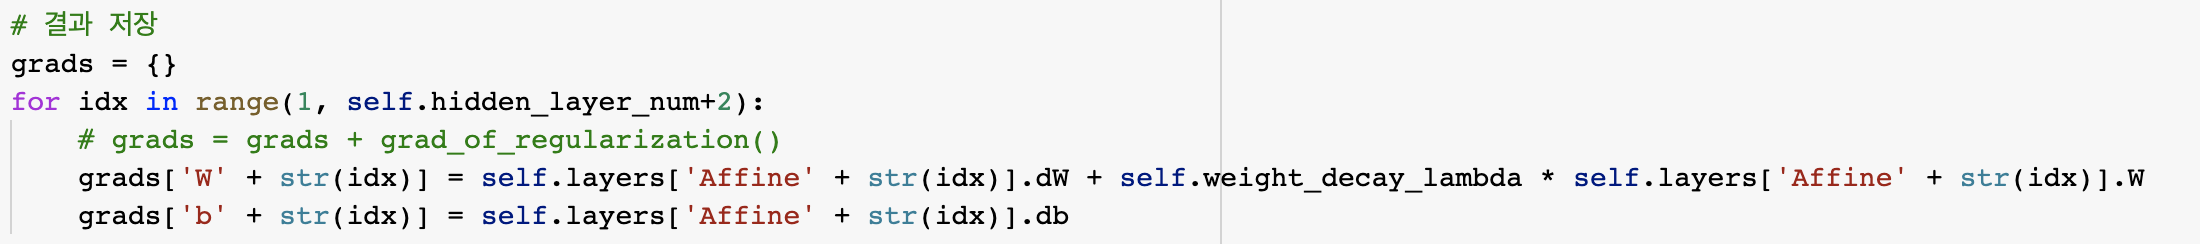

epoch:0, train acc:0.12333333333333334, test acc:0.1047
epoch:1, train acc:0.16333333333333333, test acc:0.1286
epoch:2, train acc:0.19666666666666666, test acc:0.1484
epoch:3, train acc:0.22333333333333333, test acc:0.1647
epoch:4, train acc:0.24333333333333335, test acc:0.1792
epoch:5, train acc:0.27, test acc:0.2021
epoch:6, train acc:0.29, test acc:0.2172
epoch:7, train acc:0.33666666666666667, test acc:0.2378
epoch:8, train acc:0.39666666666666667, test acc:0.2759
epoch:9, train acc:0.4166666666666667, test acc:0.2949
epoch:10, train acc:0.43333333333333335, test acc:0.3075
epoch:11, train acc:0.4666666666666667, test acc:0.3193
epoch:12, train acc:0.5033333333333333, test acc:0.3504
epoch:13, train acc:0.5333333333333333, test acc:0.3756
epoch:14, train acc:0.5733333333333334, test acc:0.3906
epoch:15, train acc:0.58, test acc:0.3933
epoch:16, train acc:0.5866666666666667, test acc:0.4043
epoch:17, train acc:0.5866666666666667, test acc:0.4089
epoch:18, train acc:0.59333333333333

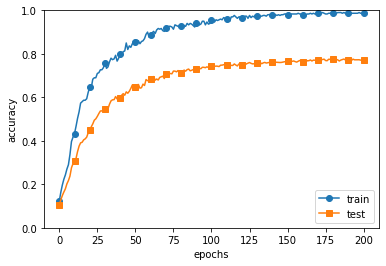

In [102]:
# coding: utf-8
import os
import sys

sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import numpy as np
import matplotlib.pyplot as plt
from common.multi_layer_net import MultiLayerNet
from dataset.mnist import load_mnist
from common.optimizer import *

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

# 오버피팅을 재현하기 위해 학습 데이터 수를 줄임
x_train = x_train[:300]
t_train = t_train[:300]

# weight decay（가중치 감쇠） 설정 =======================
# weight_decay_lambda = 0 # weight decay를 사용하지 않을 경우
weight_decay_lambda = 0.05
seed = 0
# ====================================================

seed_everything(seed)
network = MultiLayerNet(input_size=784, hidden_size_list=[100, 100, 100, 100, 100, 100], output_size=10,
                        weight_decay_lambda=weight_decay_lambda)
optimizer = SGD(lr=0.01) # 학습률이 0.01인 SGD로 매개변수 갱신

max_epochs = 201
train_size = x_train.shape[0]
batch_size = 100
seed = 0

train_loss_list = []
train_acc_list = []
test_acc_list = []

iter_per_epoch = max(train_size / batch_size, 1)
epoch_cnt = 0

for i in range(1000000000):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]

    grads = network.gradient(x_batch, t_batch)
    optimizer.update(network.params, grads)

    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)

        print("epoch:" + str(epoch_cnt) + ", train acc:" + str(train_acc) + ", test acc:" + str(test_acc))

        epoch_cnt += 1
        if epoch_cnt >= max_epochs:
            break


# 그래프 그리기==========
markers = {'train': 'o', 'test': 's'}
x = np.arange(max_epochs)
plt.plot(x, train_acc_list, marker='o', label='train', markevery=10)
plt.plot(x, test_acc_list, marker='s', label='test', markevery=10)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()

드롭아웃(dropout)
- dropout_ratio = 0.05 실험

train loss:2.332378787655405
=== epoch:1, train acc:0.11333333333333333, test acc:0.1035 ===
train loss:2.3339509947026484
train loss:2.320990592268413
train loss:2.261795690361159
=== epoch:2, train acc:0.13666666666666666, test acc:0.111 ===
train loss:2.2686851472134792
train loss:2.3014637258424817
train loss:2.2660119044910734
=== epoch:3, train acc:0.15666666666666668, test acc:0.1281 ===
train loss:2.2820497866086553
train loss:2.2287477814491483
train loss:2.2703967060633388
=== epoch:4, train acc:0.17, test acc:0.1389 ===
train loss:2.2608802043171616
train loss:2.250402555199318
train loss:2.2221451698431736
=== epoch:5, train acc:0.19, test acc:0.1511 ===
train loss:2.2488322033492483
train loss:2.247723475542769
train loss:2.239905697184796
=== epoch:6, train acc:0.21666666666666667, test acc:0.1646 ===
train loss:2.2229512023615845
train loss:2.2331373731995727
train loss:2.2496500731333815
=== epoch:7, train acc:0.23, test acc:0.1723 ===
train loss:2.2437916840604886
trai

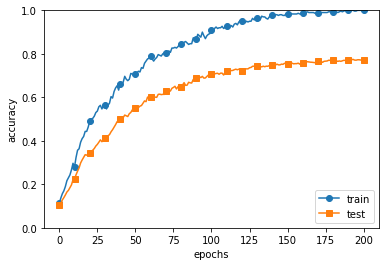

In [103]:
# coding: utf-8
import os
import sys
sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from common.trainer import Trainer

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

# 오버피팅을 재현하기 위해 학습 데이터 수를 줄임
x_train = x_train[:300]
t_train = t_train[:300]

# 드롭아웃 사용 유무와 비울 설정 ========================
use_dropout = True  # 드롭아웃을 쓰지 않을 때는 False
dropout_ratio = 0.05
seed = 0
batch_size = 100
max_epochs = 201
# ====================================================

seed_everything(seed)
network = MultiLayerNetExtend(input_size=784,
                              hidden_size_list=[100, 100, 100, 100, 100, 100],
                              output_size=10, use_dropout=use_dropout,
                              dropout_ration=dropout_ratio)
trainer = Trainer(network, x_train, t_train, x_test, t_test,
                  epochs=max_epochs, mini_batch_size=batch_size,
                  optimizer='sgd', optimizer_param={'lr': 0.01}, verbose=True)
trainer.train()

train_acc_list, test_acc_list = trainer.train_acc_list, trainer.test_acc_list

# 그래프 그리기==========
markers = {'train': 'o', 'test': 's'}
x = np.arange(len(train_acc_list))
plt.plot(x, train_acc_list, marker='o', label='train', markevery=10)
plt.plot(x, test_acc_list, marker='s', label='test', markevery=10)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()

# 하이퍼파라미터 최적화
- 데이터셋, 모델 크기가 크기 때문에 하이퍼파라미터 최적화에 많은 시간 소요됨(많은 모델 학습 필요)
- 가급적 훈련 데이터셋의 일부를 사용하여 빠르게 하이퍼파라미터 탐색하는 것 권장

val acc:0.79 | lr:0.013981961408994041, weight decay:0.004430375245218264
val acc:0.2 | lr:0.0009968124406814, weight decay:0.00014520751639379183
val acc:0.22 | lr:0.001009309776229106, weight decay:0.07179346835135739
val acc:0.84 | lr:0.06374090416506084, weight decay:0.00030081520583889244
val acc:0.06 | lr:0.0001849372770082432, weight decay:0.00021695623727274973
val acc:0.83 | lr:0.08306854890536895, weight decay:0.0020161035565458563
val acc:0.82 | lr:0.011061975052459452, weight decay:0.0008091001636612169
val acc:0.1 | lr:0.00010025975507780104, weight decay:0.0003277236953104931
val acc:0.74 | lr:0.004629395744770385, weight decay:0.0028039957220062726
val acc:0.1 | lr:0.0006535402213934306, weight decay:0.01057686079610262
val acc:0.77 | lr:0.014828241574814471, weight decay:0.0027856141699393873
val acc:0.85 | lr:0.05409074378242784, weight decay:0.010613659604406639
val acc:0.81 | lr:0.08341240924756742, weight decay:0.0006395365134797946
val acc:0.16 | lr:0.0002954442122

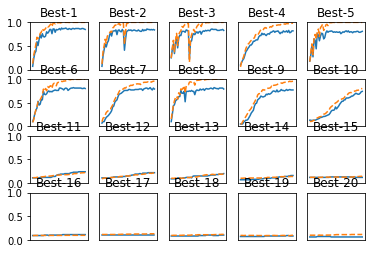

In [104]:
# coding: utf-8
import sys
import os
sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from common.multi_layer_net import MultiLayerNet
from common.util import shuffle_dataset
from common.trainer import Trainer

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

# 결과를 빠르게 얻기 위해 훈련 데이터를 줄임
x_train = x_train[:500]
t_train = t_train[:500]
seed = 0

# 20%를 검증 데이터로 분할
validation_rate = 0.20
validation_num = int(x_train.shape[0] * validation_rate)
x_train, t_train = shuffle_dataset(x_train, t_train)
x_val = x_train[:validation_num]
t_val = t_train[:validation_num]
x_train = x_train[validation_num:]
t_train = t_train[validation_num:]


def __train(lr, weight_decay, epocs=50):
    network = MultiLayerNet(input_size=784,
                            hidden_size_list=[100, 100, 100, 100, 100, 100],
                            output_size=10, weight_decay_lambda=weight_decay)
    trainer = Trainer(network, x_train, t_train, x_val, t_val,
                      epochs=epocs, mini_batch_size=100,
                      optimizer='sgd',
                      optimizer_param={'lr': lr}, verbose=False)
    trainer.train()

    return trainer.test_acc_list, trainer.train_acc_list


# 하이퍼파라미터 무작위 탐색======================================
optimization_trial = 20
results_val = {}
results_train = {}
seed_everything(seed)
for _ in range(optimization_trial):
    # 탐색한 하이퍼파라미터의 범위 지정===============
    weight_decay = 10 ** np.random.uniform(-4, -1)
    lr = 10 ** np.random.uniform(-4, -1)
    # ================================================

    val_acc_list, train_acc_list = __train(lr, weight_decay)
    print("val acc:" + str(val_acc_list[-1]) + " | lr:" + str(lr) + ", weight decay:" + str(weight_decay))
    key = "lr:" + str(lr) + ", weight decay:" + str(weight_decay)
    results_val[key] = val_acc_list
    results_train[key] = train_acc_list


# 그래프 그리기========================================================
print("=========== Hyper-Parameter Optimization Result ===========")
graph_draw_num = 20
col_num = 5
row_num = int(np.ceil(graph_draw_num / col_num))
i = 0

for key, val_acc_list in sorted(results_val.items(), key=lambda x: x[1][-1], reverse=True):
    print("Best-" + str(i+1) + "(val acc:" + str(val_acc_list[-1]) + ") | " + key)

    plt.subplot(row_num, col_num, i+1)
    plt.title("Best-" + str(i+1))
    plt.ylim(0.0, 1.0)
    if i % 5:
        plt.yticks([])
    plt.xticks([])
    x = np.arange(len(val_acc_list))
    plt.plot(x, val_acc_list)
    plt.plot(x, results_train[key], "--")
    i += 1

    if i >= graph_draw_num:
        break

plt.show()

# 실습 과제: 개선시도 4가지, 0.9 이상 val accuracy 달성
아래의 4가지를 모두 개선 시도하여 0.9 이상 val accuracy 달성하시오. 단, 딥러닝 프레임워크(PyTorch 등), 학습된 모델, CNN 사용 불가합니다.

* 1) 네트워크 구조 개선: hidden_size_list 수정하기 (레이어 개수 조절, 레이어 별 feature 개수 조절 등)
* 2) 배치 정규화 사용
* 3) 과적합 개선: weight_decay > 0, dropout_ratio > 0 파라미터 사용
* 4) 하이퍼파라미터 최적화: lr, weight_decay, dropout_ratio 최적화 코드 작성
* 유의사항: 다른 코드 부분 수정 불가

MultiLayerNetExtend 클래스 정의

In [105]:
# coding: utf-8
import sys, os
sys.path.append(os.pardir) # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import numpy as np
from collections import OrderedDict
from common.layers import *
from common.gradient import numerical_gradient

class MultiLayerNetExtend:
    """완전 연결 다층 신경망(확장판)
    가중치 감소, 드롭아웃, 배치 정규화 구현
    Parameters
    ----------
    input_size : 입력 크기（MNIST의 경우엔 784）
    hidden_size_list : 각 은닉층의 뉴런 수를 담은 리스트（e.g. [100, 100, 100]）
    output_size : 출력 크기（MNIST의 경우엔 10）
    activation : 활성화 함수 - 'relu' 혹은 'sigmoid'
    weight_init_std : 가중치의 표준편차 지정（e.g. 0.01）
        'relu'나 'he'로 지정하면 'He 초깃값'으로 설정
        'sigmoid'나 'xavier'로 지정하면 'Xavier 초깃값'으로 설정
    weight_decay_lambda : 가중치 감소(L2 법칙)의 세기
    use_dropout : 드롭아웃 사용 여부
    dropout_ration : 드롭아웃 비율
    use_batchNorm : 배치 정규화 사용 여부
    """
    def __init__(self, input_size, hidden_size_list, output_size,
                 activation='relu', weight_init_std='relu', weight_decay_lambda=0, 
                 use_dropout = False, dropout_ration = 0.5, use_batchnorm=False):
        self.input_size = input_size
        self.output_size = output_size
        self.hidden_size_list = hidden_size_list
        self.hidden_layer_num = len(hidden_size_list)
        self.use_dropout = use_dropout
        self.weight_decay_lambda = weight_decay_lambda
        self.use_batchnorm = use_batchnorm
        self.params = {}

        # 가중치 초기화
        self.__init_weight(weight_init_std)

        # 계층 생성
        activation_layer = {'sigmoid': Sigmoid, 'relu': Relu}
        self.layers = OrderedDict()
        for idx in range(1, self.hidden_layer_num+1):
            self.layers['Affine' + str(idx)] = Affine(self.params['W' + str(idx)],
                                                      self.params['b' + str(idx)])
            if self.use_batchnorm:
                self.params['gamma' + str(idx)] = np.ones(hidden_size_list[idx-1])
                self.params['beta' + str(idx)] = np.zeros(hidden_size_list[idx-1])
                self.layers['BatchNorm' + str(idx)] = BatchNormalization(self.params['gamma' + str(idx)], self.params['beta' + str(idx)])
                
            self.layers['Activation_function' + str(idx)] = activation_layer[activation]()
            
            if self.use_dropout:
                self.layers['Dropout' + str(idx)] = Dropout(dropout_ration)

        idx = self.hidden_layer_num + 1
        self.layers['Affine' + str(idx)] = Affine(self.params['W' + str(idx)], self.params['b' + str(idx)])

        self.last_layer = SoftmaxWithLoss()

    def __init_weight(self, weight_init_std):
        """가중치 초기화
        
        Parameters
        ----------
        weight_init_std : 가중치의 표준편차 지정（e.g. 0.01）
            'relu'나 'he'로 지정하면 'He 초깃값'으로 설정
            'sigmoid'나 'xavier'로 지정하면 'Xavier 초깃값'으로 설정
        """
        all_size_list = [self.input_size] + self.hidden_size_list + [self.output_size]
        for idx in range(1, len(all_size_list)):
            scale = weight_init_std
            if str(weight_init_std).lower() in ('relu', 'he'):
                scale = np.sqrt(2.0 / all_size_list[idx - 1])  # ReLUを使う場合に推奨される初期値
            elif str(weight_init_std).lower() in ('sigmoid', 'xavier'):
                scale = np.sqrt(1.0 / all_size_list[idx - 1])  # sigmoidを使う場合に推奨される初期値
            self.params['W' + str(idx)] = scale * np.random.randn(all_size_list[idx-1], all_size_list[idx])
            self.params['b' + str(idx)] = np.zeros(all_size_list[idx])

    def predict(self, x, train_flg=False):
        for key, layer in self.layers.items():
            if "Dropout" in key or "BatchNorm" in key:
                x = layer.forward(x, train_flg)
            else:
                x = layer.forward(x)

        return x

    def loss(self, x, t, train_flg=False):
        """손실 함수를 구한다.
        
        Parameters
        ----------
        x : 입력 데이터
        t : 정답 레이블 
        """
        y = self.predict(x, train_flg)

        weight_decay = 0
        for idx in range(1, self.hidden_layer_num + 2):
            W = self.params['W' + str(idx)]
            weight_decay += 0.5 * self.weight_decay_lambda * np.sum(W**2)

        return self.last_layer.forward(y, t) + weight_decay

    def accuracy(self, X, T):
        Y = self.predict(X, train_flg=False)
        Y = np.argmax(Y, axis=1)
        if T.ndim != 1 : T = np.argmax(T, axis=1)

        accuracy = np.sum(Y == T) / float(X.shape[0])
        return accuracy

    def numerical_gradient(self, X, T):
        """기울기를 구한다(수치 미분).
        
        Parameters
        ----------
        x : 입력 데이터
        t : 정답 레이블
        
        Returns
        -------
        각 층의 기울기를 담은 사전(dictionary) 변수
            grads['W1']、grads['W2']、... 각 층의 가중치
            grads['b1']、grads['b2']、... 각 층의 편향
        """
        loss_W = lambda W: self.loss(X, T, train_flg=True)

        grads = {}
        for idx in range(1, self.hidden_layer_num+2):
            grads['W' + str(idx)] = numerical_gradient(loss_W, self.params['W' + str(idx)])
            grads['b' + str(idx)] = numerical_gradient(loss_W, self.params['b' + str(idx)])
            
            if self.use_batchnorm and idx != self.hidden_layer_num+1:
                grads['gamma' + str(idx)] = numerical_gradient(loss_W, self.params['gamma' + str(idx)])
                grads['beta' + str(idx)] = numerical_gradient(loss_W, self.params['beta' + str(idx)])

        return grads
        
    def gradient(self, x, t):
        # forward
        self.loss(x, t, train_flg=True)

        # backward
        dout = 1
        dout = self.last_layer.backward(dout)

        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)

        # 결과 저장
        grads = {}
        for idx in range(1, self.hidden_layer_num+2):
            grads['W' + str(idx)] = self.layers['Affine' + str(idx)].dW + self.weight_decay_lambda * self.params['W' + str(idx)]
            grads['b' + str(idx)] = self.layers['Affine' + str(idx)].db

            if self.use_batchnorm and idx != self.hidden_layer_num+1:
                grads['gamma' + str(idx)] = self.layers['BatchNorm' + str(idx)].dgamma
                grads['beta' + str(idx)] = self.layers['BatchNorm' + str(idx)].dbeta

        return grads

실습과제 코드
* 1) 네트워크 구조 개선: hidden_size_list 수정하기 (레이어 개수 조절, 레이어 별 feature 개수 조절 등)
* 2) 배치 정규화 사용
* 3) 과적합 개선: weight_decay > 0, dropout_ratio > 0 파라미터 사용
* 4) 하이퍼파라미터 최적화: lr, weight_decay, dropout_ratio 최적화 코드 작성
* 유의사항: 다른 코드 부분 수정 불가

val acc:0.39 | lr:0.001014671739441802, weight decay:0.0005547119471592124 , dropout ratio:0.00016570805984346854
val acc:0.9 | lr:0.018322017722694723, weight decay:0.001595779437015633 , dropout ratio:7.689789020056158e-07
val acc:0.05 | lr:4.199422755226032e-06, weight decay:0.05908782036558857 , dropout ratio:1.1957387967332337e-08
val acc:0.08 | lr:3.691557336280515e-05, weight decay:8.492492148386718e-06 , dropout ratio:0.00015009076799672025
val acc:0.1 | lr:5.6841930171497545e-05, weight decay:0.0036480102209672364 , dropout ratio:1.3864848533328735e-05
val acc:0.92 | lr:0.04868992706822099, weight decay:0.00032683857041798577 , dropout ratio:1.7258711609529233e-08
val acc:0.12 | lr:8.208261235311221e-07, weight decay:0.08050307131851443 , dropout ratio:5.0902062409692026e-05
val acc:0.13 | lr:7.3961482156282235e-06, weight decay:2.259714615751989e-06 , dropout ratio:0.00153600576853342
val acc:0.12 | lr:6.830431237715029e-07, weight decay:1.603345985531314e-06 , dropout ratio:

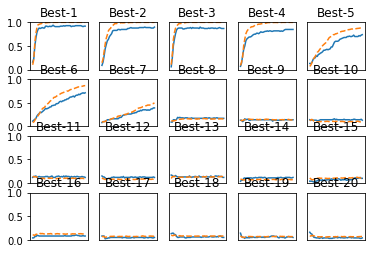

In [143]:
# coding: utf-8
import sys
import os
sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from common.util import shuffle_dataset
from common.trainer import Trainer

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

# 결과를 빠르게 얻기 위해 훈련 데이터를 줄임
x_train = x_train[:500]
t_train = t_train[:500]
seed = 0
use_dropout = True  # 드롭아웃 사용
use_batchnorm = True  # 배치 정규화 사용

# 20%를 검증 데이터로 분할
validation_rate = 0.20
validation_num = int(x_train.shape[0] * validation_rate)
x_train, t_train = shuffle_dataset(x_train, t_train)
x_val = x_train[:validation_num]
t_val = t_train[:validation_num]
x_train = x_train[validation_num:]
t_train = t_train[validation_num:]


def __train(lr, weight_decay, dropout_ratio, epochs=50):
    network = MultiLayerNetExtend(input_size=784,
                                   hidden_size_list=[120,120,120],
                                  output_size=10, use_dropout=use_dropout,
                                  use_batchnorm=use_batchnorm,
                                  dropout_ration=dropout_ratio)
    trainer = Trainer(network, x_train, t_train, x_val, t_val,
                      epochs=epochs, mini_batch_size=100,
                      optimizer='sgd',
                      optimizer_param={'lr': lr}, verbose=False)
    trainer.train()

    return trainer.test_acc_list, trainer.train_acc_list


# 하이퍼파라미터 무작위 탐색======================================
optimization_trial = 20
results_val = {}
results_train = {}
seed_everything(seed)
for _ in range(optimization_trial):
    # 탐색한 하이퍼파라미터의 범위 지정===============
    weight_decay =10 ** np.random.uniform(-6, -1)
    lr = 10 ** np.random.uniform(-8, -1)
    dropout_ratio = 10 ** np.random.uniform(-8, -1)


    # ================================================

    val_acc_list, train_acc_list = __train(lr, weight_decay, dropout_ratio)
    print("val acc:" + str(val_acc_list[-1]) + " | lr:" + str(lr) + ", weight decay:" + str(weight_decay),
          ", dropout ratio:" + str(dropout_ratio))
    key = "lr:" + str(lr) + ", weight decay:" + str(weight_decay) + ", dropout ratio:" + str(dropout_ratio)
    results_val[key] = val_acc_list
    results_train[key] = train_acc_list


# 그래프 그리기========================================================
print("=========== Hyper-Parameter Optimization Result ===========")
graph_draw_num = 20
col_num = 5
row_num = int(np.ceil(graph_draw_num / col_num))
i = 0

for key, val_acc_list in sorted(results_val.items(), key=lambda x: x[1][-1], reverse=True):
    print("Best-" + str(i+1) + "(val acc:" + str(val_acc_list[-1]) + ") | " + key)

    plt.subplot(row_num, col_num, i+1)
    plt.title("Best-" + str(i+1))
    plt.ylim(0.0, 1.0)
    if i % 5:
        plt.yticks([])
    plt.xticks([])
    x = np.arange(len(val_acc_list))
    plt.plot(x, val_acc_list)
    plt.plot(x, results_train[key], "--")
    i += 1

    if i >= graph_draw_num:
        break

plt.show()

#val acc:0.92 | lr:0.9761079285242066, weight decay:0.00016130766119300165 , dropout ratio:0.0018419025801216138